# Imports

In [251]:
#!pip install transformers==3.5.0
#!pip install torch==1.7.1
#!pip install tensorflow==1.4.0

In [252]:
import numpy as np
import json
import pandas as pd
import re

from transformers import AutoTokenizer

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [253]:
#!pip install palettable
from palettable.cmocean.diverging import Curl_8, Curl_16

# Functions 

In [254]:
def types_col(df):

    question_types = []

    for idx, row in df.iterrows():

        question = row['question']

        matches = [x for x in types.keys() if x.lower() in question.lower()]
        if len(matches) == 0:
            matches = ['Undetermined']
        question_types.append(matches)
        
    return question_types


In [255]:
def types_keys(df, types_dict):
    
    coded_types = []
    types_lst = df['Q Types'].to_list()
    
    for item in types_lst:
        coded_types.append(types_dict.get(item[0])) 
        
    return coded_types

In [256]:
def vectorise_questions(df):
    
    tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
    
    questions_lst = df['question'].values
    
    inputs = tokenizer.batch_encode_plus(questions_lst, add_special_tokens=False)
    encoded_questions = inputs['input_ids']
    
    return encoded_questions

In [257]:
def vector_reduce(df_col):
    
    vector_df = pd.DataFrame.from_records(df_col.values)
    vector_df = vector_df.fillna(0)
    
    pca2 = PCA(n_components=2)
    vector_2d = pca2.fit_transform(vector_df)
    
    return list(vector_2d)

In [258]:
def clean_df(df):
    df['Reduced Vector'] = vector_reduce(df['Vectors'])
    df['Reduced Vector'] = df['Reduced Vector'].apply(lambda x: x.tolist())
    df['Q Types'] = df['Q Types'].apply(lambda x: x[0])
        

In [259]:
def plot_df(vect_col, type_col):
    
    lst_vect = vect_col.values.tolist()
    
    plot_df = pd.DataFrame.from_records(lst_vect, columns=['x', 'y'])
    plot_df['Colours'] = type_col
    
    return plot_df
    

In [260]:
def read_data(file_path, generated_q, types):
    dataframe = pd.read_csv(file_path, index_col=0)
    
    if generated_q == 1:
        dataframe.columns = ['context', 'question', 'pred', 'original question', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4', 'Meteor']
    else:
        dataframe.columns = ['context', 'question', 'answer_start', 'text', 'pred', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4', 'Meteor']
        
    dataframe['Q Types'] = types_col(dataframe)
    dataframe['Type Code'] = types_keys(dataframe, types)
    
    #vectorise the questions - either the original or the generated
    dataframe['Vectors'] = vectorise_questions(dataframe)
    
    clean_df(dataframe)
    
    # drop rows where there are no questions - this happens when the qgen model loop moves on, creates a new graph and 
    # doesn't let the generation finish to produce a question - normally on the last loop of every context
    dataframe = dataframe[~dataframe['question'].isin(['None'])]
    
        
    return dataframe

In [261]:
def threshold(dataframe, thresh_val, metric_col, gen):
        
    if len(metric_col) == 2:
        threshold_df = dataframe[(dataframe[metric_col[0]] < thresh_val) & (dataframe[metric_col[1]] < thresh_val)]
    else:
        threshold_df = dataframe[dataframe[metric_col[0]] < thresh_val]
        
    # also have to consider if the question was answered
    #if gen == True:
        #threshold_df = threshold_df[threshold_df['pred'].isin([' ', '[CLS]', 'cannotanswer'])]
    
    # label original dataframe based on threshold - 
    thresh_idx = threshold_df.index.values.tolist()
    dataframe.loc[thresh_idx,'Answered'] = 'Incorrect'
    dataframe.Answered = dataframe.Answered.fillna('Correct')
        
    threshold_df = threshold_df.reset_index(drop=True)
    
    print('Average Metric Score: ' + str(threshold_df[metric_col].mean()))
    print('Length of Threshold Samples: ' + str(len(threshold_df)))
    print('% of total: ' + str(len(threshold_df)/len(dataframe)))
    
    stats_list = [list(threshold_df[metric_col].mean())[0], list(threshold_df[metric_col].mean())[1], 
                  len(threshold_df), len(threshold_df)/len(dataframe), 
                  threshold_df.loc[threshold_df.pred == '[CLS]', 'pred'].count(),
                  threshold_df.loc[threshold_df.pred == ' ', 'pred'].count()
                 ]
    
    return threshold_df, stats_list

In [262]:
def cluster_plot(dataframe, title, filename):
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=plot_df(dataframe['Reduced Vector'], dataframe['Q Types']), x="x", y="y", hue="Colours", palette = 'rocket')
    plt.title(title)
    plt.savefig(filename, transparent=True)

In [263]:
def count_chart(dataframe, title, filename):
    plt.figure(figsize=(12, 8))

    sns.countplot(x="Q Types", data=dataframe, palette = 'rocket')
    plt.title(title)
    plt.savefig(filename, transparent=True)

In [264]:
def ordered_count(dataframe):
    counts = []
    sub_counts = []
    sub_cats = []
    for idx, key in enumerate(types.keys()):

        counts.append(np.sum(dataframe['Q Types'] == key))
        sub_counts.append(np.sum((dataframe['Q Types'] == key) & (dataframe['Answered'] == 'Correct')))
        sub_cats.append(key+'.'+'correct')
        sub_counts.append(np.sum((dataframe['Q Types'] == key) & (dataframe['Answered'] == 'Incorrect')))
        sub_cats.append(key+'.'+'incorrect')
        
    return counts, sub_counts, sub_cats

In [265]:
def pie_chart(dataframe, title, filename):
    
    plt.figure(figsize=(8, 8))
    
    # First Ring (outside)
    question_keys = types.keys()
    question_size, sub_questions, sub_cats = ordered_count(dataframe)

    fig, ax = plt.subplots()
    ax.axis('equal')
    mypie, _ = ax.pie(question_size, radius=2, colors=Curl_8.hex_colors, textprops={'fontsize': 12})
    plt.setp( mypie, width=0.6, edgecolor='white')

    # Second Ring (Inside)
    mypie2, _  = ax.pie(sub_questions, labels=sub_cats, labeldistance=None, radius=2-0.6, colors=Curl_16.hex_colors)
    plt.setp(mypie2, width=0.4, edgecolor='white')
    #plt.legend(sub_cats, title = "Question Breakdown", loc="center left", bbox_to_anchor=(1.4,0,0,1))
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, sub_cats, bbox_to_anchor=(1.4,0,0,1))

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(mypie):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(list(question_keys)[i], xy=(x, y), xytext=(2.5*np.sign(x), 2.5*y),
                    horizontalalignment=horizontalalignment, **kw)

    plt.title(title,  y=1.35)
    plt.margins(0,0)
    plt.savefig(filename, transparent=True,  bbox_inches="tight")

    # show it
    plt.show()

# Reading Data

### Classifying Question Types

In [266]:
# types dict for labelling
types = {'Who': 0, 'What': 1, 'Where': 2, 'When': 3, 'Why': 4, 'Which': 5, 'How': 6, 'Undetermined': 7}

In [267]:
# read in quac and squad csvs to dataframes

squad_eval = read_data('../QA/predictions/squad_metrics.csv', 0, types)
quac_eval = read_data('../QA/predictions/quac_metrics.csv', 0, types)

squad_gen = read_data('../QA/results/squad_gen_metrics.csv', 1, types)
quac_gen = read_data('../QA/results/quac_gen_metrics.csv', 1, types)
quac_squad_gen = read_data('../QA/results/quac_squad_gen_metrics.csv', 1, types)


# Threshold Analysis

In [268]:
# found upon manual inspection of the results being returned that using BLEU or Meteor score alone was causing results that 
# where otherwise mostly correct to be returned as poor samples, this approach uses both and only returns those that are
# determined as poor by both metrics

In [269]:
squad_eval_thresh, squad_stats = threshold(squad_eval, 0.2, ['BLEU1','Meteor'], False)

Average Metric Score: BLEU1     0.035058
Meteor    0.024263
dtype: float64
Length of Threshold Samples: 839
% of total: 0.14153171390013494


In [270]:
print(squad_eval_thresh.loc[squad_eval_thresh.pred == '[CLS]', 'pred'].count())
print(squad_eval_thresh.loc[squad_eval_thresh.pred == ' ', 'pred'].count())
print('Length of dataframe without blank predictions: ' + str(len(squad_eval_thresh[~squad_eval_thresh['pred'].isin([' '])])))

317
114
Length of dataframe without blank predictions: 725


In [271]:
#squad_eval_thresh

In [272]:
quac_eval_thresh, quac_stats = threshold(quac_eval, 0.2, ['BLEU1','Meteor'], False)


Average Metric Score: BLEU1     0.037575
Meteor    0.021390
dtype: float64
Length of Threshold Samples: 4042
% of total: 0.5496328528691868


In [273]:
#quac_eval_thresh

In [274]:
print(quac_eval_thresh.loc[quac_eval_thresh.pred == '[CLS]', 'pred'].count())
print(quac_eval_thresh.loc[quac_eval_thresh.pred == ' ', 'pred'].count())
print('Length of dataframe without blank predictions: ' + str(len(quac_eval_thresh[~quac_eval_thresh['pred'].isin([' '])])))

1641
525
Length of dataframe without blank predictions: 3517


In [275]:
squad_gen_thresh, squad_gen_stats = threshold(squad_gen, 0.2, ['BLEU4', 'Meteor'], True)

Average Metric Score: BLEU4     0.151847
Meteor    0.097833
dtype: float64
Length of Threshold Samples: 1020
% of total: 0.18146237324319517


In [276]:
print(squad_gen_thresh.loc[squad_gen_thresh.pred == '[CLS]', 'pred'].count())
print(squad_gen_thresh.loc[squad_gen_thresh.pred == ' ', 'pred'].count())
print('Length of dataframe without blank predictions: ' + str(len(squad_gen_thresh[~squad_gen_thresh['pred'].isin([' '])])))

395
51
Length of dataframe without blank predictions: 969


In [277]:
#squad_gen_thresh

In [278]:
quac_gen_thresh, quac_gen_stats = threshold(quac_gen, 0.2, ['BLEU4', 'Meteor'], True)

Average Metric Score: BLEU4     0.175867
Meteor    0.088339
dtype: float64
Length of Threshold Samples: 394
% of total: 0.42872687704026113


In [279]:
#quac_gen_thresh

In [280]:
print(quac_gen_thresh.loc[quac_gen_thresh.pred == '[CLS]', 'pred'].count())
print(quac_gen_thresh.loc[quac_gen_thresh.pred == ' ', 'pred'].count())
print('Length of dataframe without blank predictions: ' + str(len(quac_gen_thresh[~quac_gen_thresh['pred'].isin([' '])])))


121
0
Length of dataframe without blank predictions: 394


In [281]:
quac_squad_gen_thresh, quac_squad_gen_stats = threshold(quac_squad_gen, 0.2, ['BLEU4', 'Meteor'], True)

Average Metric Score: BLEU4     0.175867
Meteor    0.088339
dtype: float64
Length of Threshold Samples: 394
% of total: 0.42872687704026113


In [282]:
print(quac_squad_gen_thresh.loc[quac_squad_gen_thresh.pred == '[CLS]', 'pred'].count())
print(quac_squad_gen_thresh.loc[quac_squad_gen_thresh.pred == ' ', 'pred'].count())
print('Length of dataframe without blank predictions: ' + str(len(quac_squad_gen_thresh[~quac_squad_gen_thresh['pred'].isin([' '])])))


112
0
Length of dataframe without blank predictions: 394


In [317]:
stats = ['Average BLEU', 'Average Meteor', 'Num below Threshold', '% of Total', 'Num of [CLS]', 'Num of blanks']
stats_matrix = [squad_stats, quac_stats, squad_gen_stats, quac_gen_stats, quac_squad_gen_stats]
row_names = ['SQuAD', 'QuAC', 'SQuAD Gen', 'QuAC Gen', 'QuAC Gen SQuAD Pred']

stats_df = pd.DataFrame(stats_matrix, columns=stats)
stats_df.insert(loc=0, column='Type', value=row_names)

In [318]:
answered = [
    len(squad_eval[squad_eval['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(squad_eval),
    len(quac_eval[quac_eval['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(quac_eval),
    len(squad_gen[squad_gen['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(squad_gen),
    len(quac_gen[quac_gen['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(quac_gen),
    len(quac_squad_gen[quac_squad_gen['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(quac_squad_gen)
]
stats_df['% Unanswered'] = answered

In [324]:
answered_thresh = [
    len(squad_eval_thresh[squad_eval_thresh['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(squad_eval),
    len(quac_eval_thresh[quac_eval_thresh['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(quac_eval),
    len(squad_gen_thresh[squad_gen_thresh['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(squad_gen),
    len(quac_gen_thresh[quac_gen_thresh['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(quac_gen),
    len(quac_squad_gen_thresh[quac_squad_gen_thresh['pred'].isin([' ', '[CLS]', 'cannotanswer'])])/len(quac_squad_gen)
]
stats_df['% Unanswered under threshold'] = answered_thresh

In [325]:
stats_df

,Type,Average BLEU,Average Meteor,Num below Threshold,% of Total,Num of [CLS],Num of blanks,% Unanswered,% Unanswered under threshold
0,SQuAD,0.035058,0.024263,839,0.141532,317,114,0.108806,0.072706
1,QuAC,0.037575,0.021390,4042,0.549633,1641,525,0.536443,0.358988
2,SQuAD Gen,0.151847,0.097833,1020,0.181462,395,51,0.411137,0.079345
3,QuAC Gen,0.175867,0.088339,394,0.428727,121,0,0.479869,0.218716
4,QuAC Gen SQuAD Pred,0.175867,0.088339,394,0.428727,112,0,0.258977,0.121872


In [326]:
stats_df.to_csv('figures/threshold_stats_V2.csv')

# Clustering & Plots

## SQuAD Evaluation QA

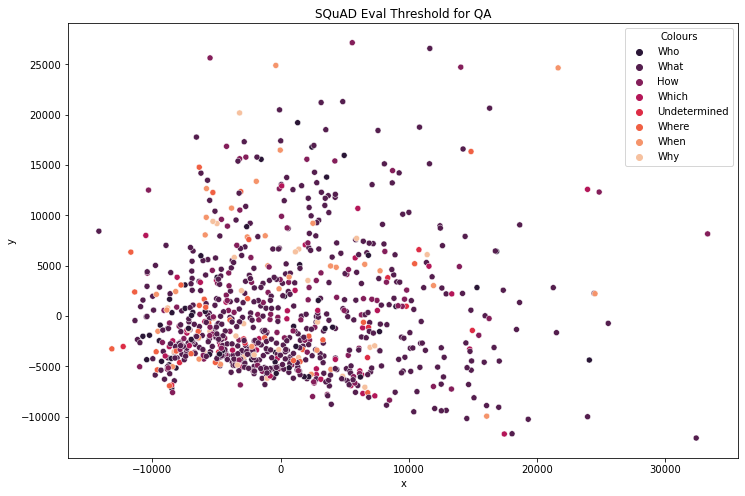

In [286]:
cluster_plot(squad_eval_thresh, 'SQuAD Eval Threshold for QA', 'figures/SQuAD Eval - Scatter.png')

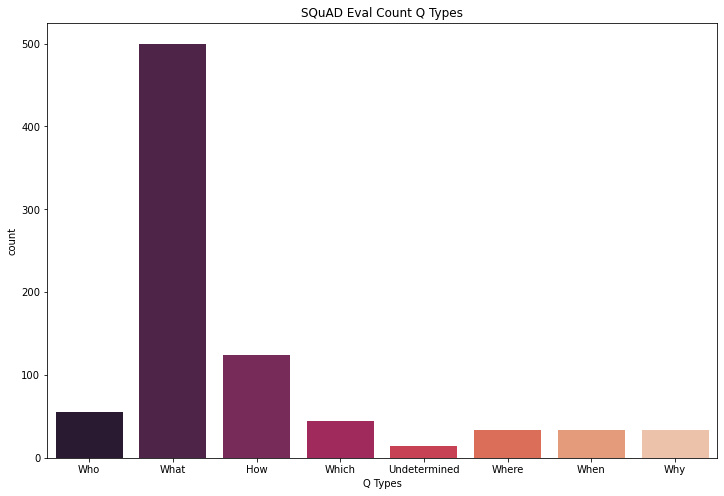

In [287]:
count_chart(squad_eval_thresh,  'SQuAD Eval Count Q Types', 'figures/SQuAD Eval - Count.png')

<Figure size 576x576 with 0 Axes>

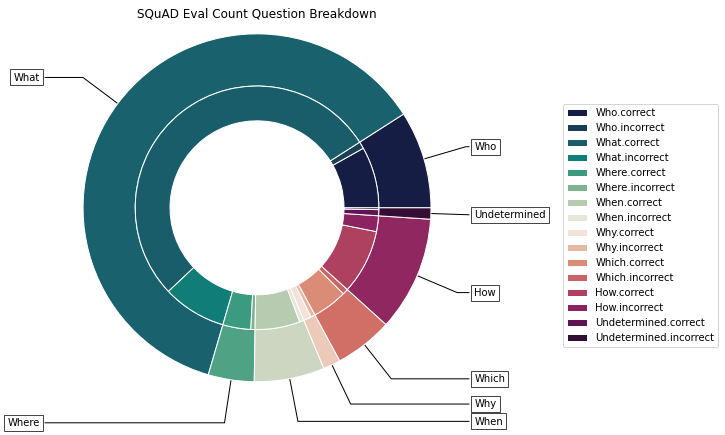

In [288]:
pie_chart(squad_eval, 'SQuAD Eval Count Question Breakdown','figures/SQuAD Eval - Donut.png')

## QuAC Evaluation QA


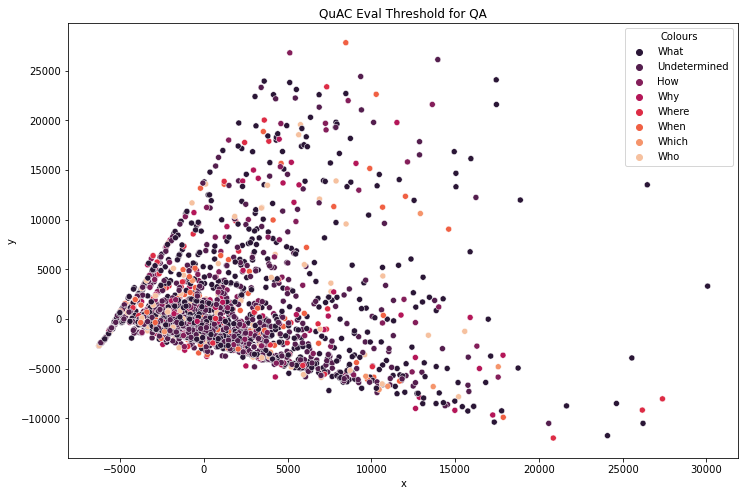

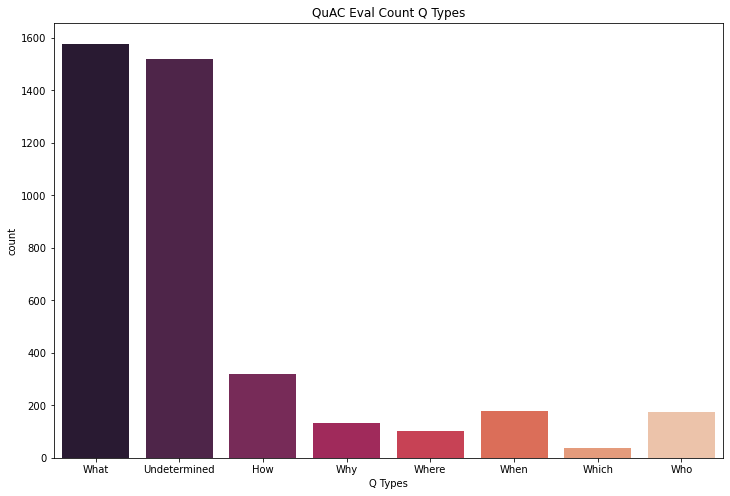

<Figure size 576x576 with 0 Axes>

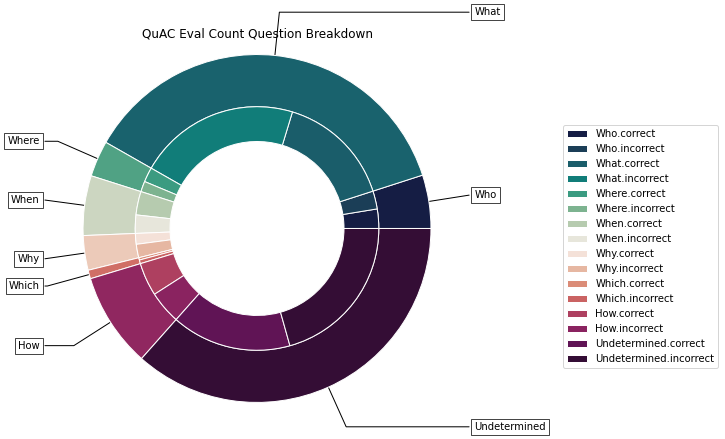

In [289]:
cluster_plot(quac_eval_thresh, 'QuAC Eval Threshold for QA', 'figures/QuAC Eval - Scatter.png')
count_chart(quac_eval_thresh,  'QuAC Eval Count Q Types', 'figures/QuAC Eval - Count.png')
pie_chart(quac_eval, 'QuAC Eval Count Question Breakdown','figures/QuAC Eval - Donut.png')

## SQuAD Gen 

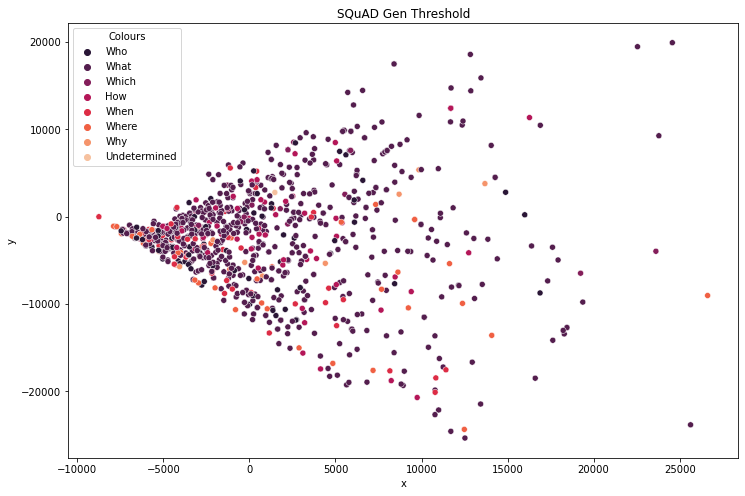

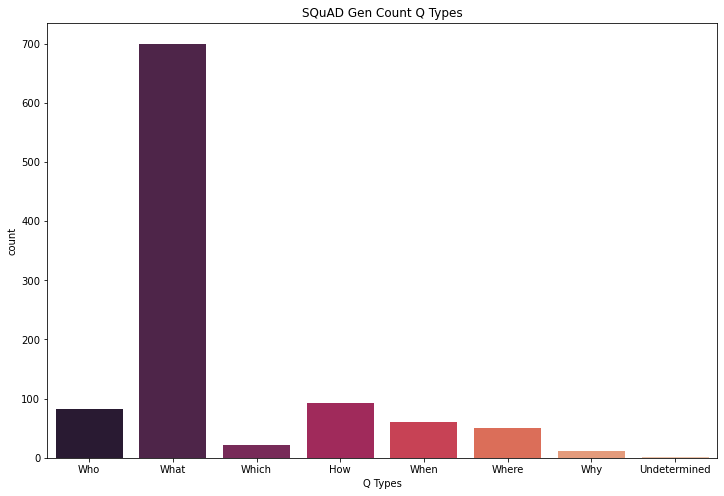

<Figure size 576x576 with 0 Axes>

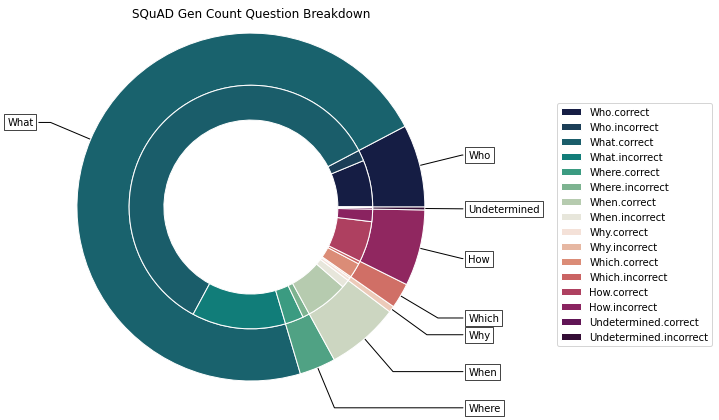

In [290]:
cluster_plot(squad_gen_thresh, 'SQuAD Gen Threshold', 'figures/SQuAD Gen - Scatter.png')
count_chart(squad_gen_thresh,  'SQuAD Gen Count Q Types', 'figures/SQuAD Gen - Count.png')
pie_chart(squad_gen, 'SQuAD Gen Count Question Breakdown','figures/SQuAD Gen - Donut.png')

## QuAC Gen

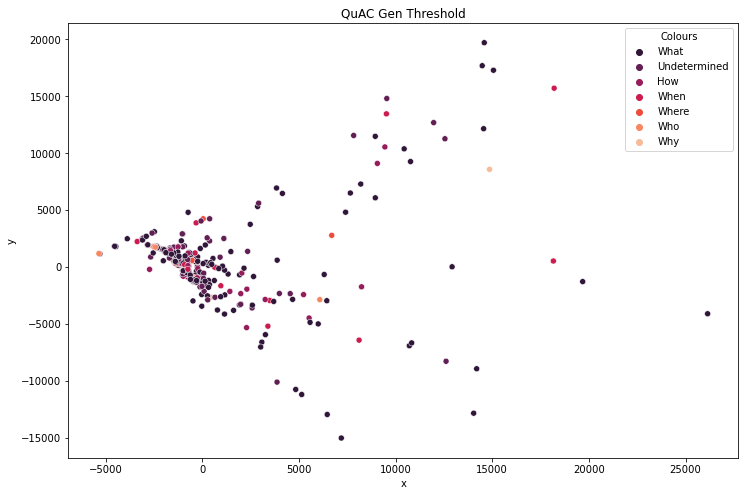

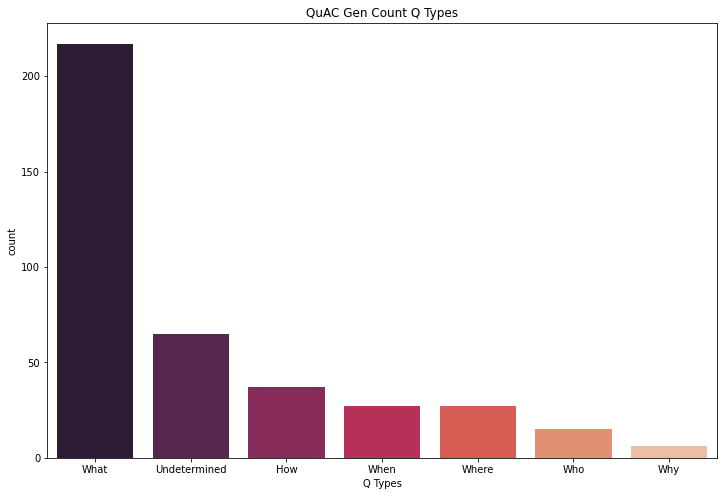

<Figure size 576x576 with 0 Axes>

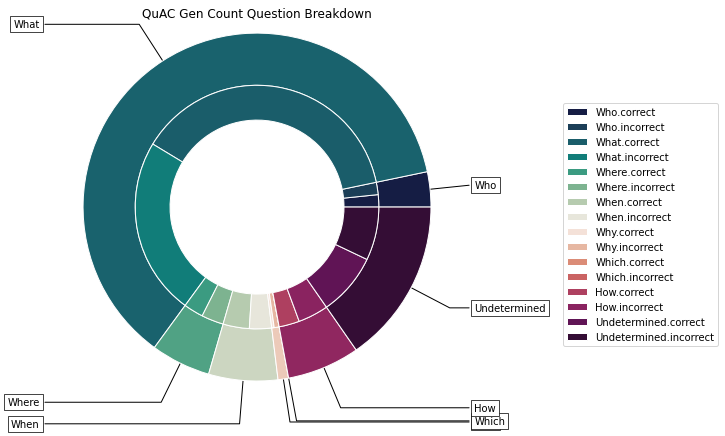

In [291]:
cluster_plot(quac_gen_thresh, 'QuAC Gen Threshold', 'figures/QuAC Gen - Scatter.png')
count_chart(quac_gen_thresh,  'QuAC Gen Count Q Types', 'figures/QuAC Gen - Count.png')
pie_chart(quac_gen, 'QuAC Gen Count Question Breakdown','figures/QuAC Gen - Donut.png')

In [292]:
# QuAC Gen SQuAD Pred

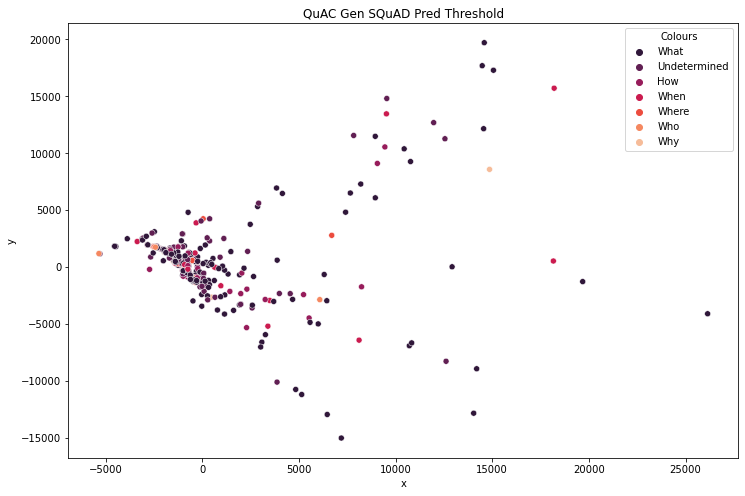

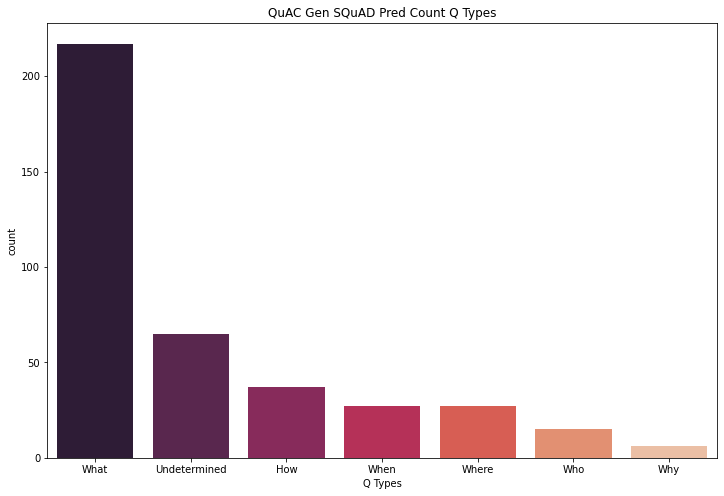

<Figure size 576x576 with 0 Axes>

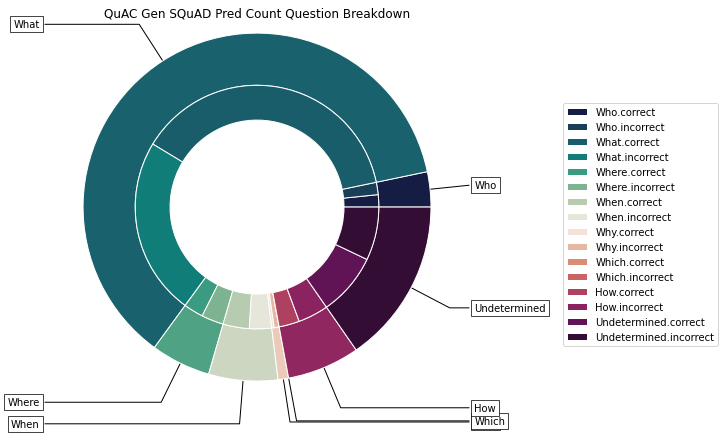

In [293]:
cluster_plot(quac_squad_gen_thresh, 'QuAC Gen SQuAD Pred Threshold', 'figures/QuAC Gen SQuAD Pred - Scatter.png')
count_chart(quac_squad_gen_thresh,  'QuAC Gen SQuAD Pred Count Q Types', 'figures/QuAC Gen SQuAD Pred - Count.png')
pie_chart(quac_squad_gen, 'QuAC Gen SQuAD Pred Count Question Breakdown','figures/QuAC Gen SQuAD Pred - Donut.png')

In [294]:
rand_5 = squad_eval.sample(5)
rand_5

,context,question,answer_start,text,pred,BLEU1,BLEU2,BLEU3,BLEU4,Meteor,Q Types,Type Code,Vectors,Reduced Vector,Answered
3433,Plotting the relationship between level of inc...,What does Kuznets' curve predict about income ...,411,eventually decrease,decrease,0.222222,0.260464,0.254780,0.234184,0.263158,What,1,"[2054, 2515, 13970, 2480, 22781, 1005, 7774, 1...","[6818.374471979127, 6900.957640680918]",Correct
4428,The fundamental theorem of arithmetic continue...,What form do complex Gaussian integers have?,196,a + bi,[CLS],0.000000,0.000000,0.000000,0.000000,0.000000,What,1,"[2054, 2433, 2079, 3375, 11721, 17854, 2937, 2...","[2598.6336482570973, 16947.539200305673]",Incorrect
3284,A study by the World Institute for Development...,How much of the global wealth will the wealthi...,949,half,more than half,0.000000,0.000000,0.000000,0.000000,0.416667,How,6,"[2129, 2172, 1997, 1996, 3795, 7177, 2097, 199...","[8221.07170972949, -2796.25360937359]",Correct
899,Most of the Huguenot congregations (or individ...,Who was one prominent Huguenot-descended arms ...,599,E.I. du Pont,du pont,0.000000,0.000000,0.000000,0.000000,0.646552,Who,0,"[2040, 2001, 2028, 4069, 8549, 24997, 4140, 10...","[1950.9611634993043, 12576.538310846825]",Correct
4855,Reserved matters are subjects that are outside...,What is the name of matters outside the legisl...,0,Reserved,reserved matters,0.333333,0.342212,0.315914,0.281535,0.454545,What,1,"[2054, 2003, 1996, 2171, 1997, 5609, 2648, 199...","[204.22365045142772, -3240.6536908928583]",Correct


In [295]:
rand_5.to_csv('eval_data_sample.csv')

In [296]:
quac_undetermined = quac_eval.loc[quac_eval['Q Types'] == 'Undetermined']

In [297]:
quac_undetermined.head(50)

,context,question,answer_start,text,pred,BLEU1,BLEU2,BLEU3,BLEU4,Meteor,Q Types,Type Code,Vectors,Reduced Vector,Answered
1,"In May 1983, she married Nikos Karvelas, a com...",did they have any children?,92,in November she gave birth to her daughter Sofia.,in november she gave birth to her daughter sof...,0.925000,0.626666,0.492660,0.404877,0.878262,Undetermined,7,"[2106, 2027, 2031, 2151, 2336, 1029]","[-3736.3922090244864, -432.8363971980638]",Correct
2,"In May 1983, she married Nikos Karvelas, a com...",did she have any other children?,2024,CANNOTANSWER,cannotanswer,0.076923,0.161497,0.190781,0.191123,0.500000,Undetermined,7,"[2106, 2016, 2031, 2151, 2060, 2336, 1029]","[-2711.58804680006, -952.4490008469478]",Correct
7,"In May 1983, she married Nikos Karvelas, a com...",did she have any other famous songs?,1049,"The album included the hit Pragmata (""Things"")...",,0.000000,0.000000,0.000000,0.000000,0.000000,Undetermined,7,"[2106, 2016, 2031, 2151, 2060, 3297, 2774, 1029]","[-1031.737772713301, -1722.619879180211]",Incorrect
8,"In September 2016 Vladimir Markin, official sp...",Did they have any clues?,1908,probably FSB) are known to have targeted the w...,cannotanswer,0.107143,0.206999,0.233870,0.228368,0.000000,Undetermined,7,"[2106, 2027, 2031, 2151, 15774, 1029]","[2417.7179293038143, -472.08283462201416]",Incorrect
10,"In September 2016 Vladimir Markin, official sp...",Did they get into trouble for that?,2294,CANNOTANSWER,cannotanswer,0.076923,0.161497,0.190781,0.191123,0.500000,Undetermined,7,"[2106, 2027, 2131, 2046, 4390, 2005, 2008, 1029]","[-998.0029925936844, -1333.893377182241]",Correct
11,"In September 2016 Vladimir Markin, official sp...",Did they have any murder suspects?,853,"After the three Makhmudov brothers, Khadjikurb...",cannotanswer,0.120000,0.216789,0.239924,0.232154,0.000000,Undetermined,7,"[2106, 2027, 2031, 2151, 4028, 13172, 1029]","[3549.043201625156, -3396.3002901251793]",Incorrect
12,"In September 2016 Vladimir Markin, official sp...",Did they go to jail?,2294,CANNOTANSWER,cannotanswer,0.076923,0.161497,0.190781,0.191123,0.500000,Undetermined,7,"[2106, 2027, 2175, 2000, 7173, 1029]","[-1547.933192382251, -538.5481782615714]",Correct
13,"In September 2016 Vladimir Markin, official sp...",Is there anything else interesting in the arti...,1107,In accordance with Russian law there is a 15-y...,,0.000000,0.000000,0.000000,0.000000,0.000000,Undetermined,7,"[2003, 2045, 2505, 2842, 5875, 1999, 1996, 372...","[1126.5469957906132, -1074.875757009739]",Incorrect
14,"In September 2016 Vladimir Markin, official sp...",Are they close to solving it?,1600,In May that year the case against him was disc...,her colleagues at novaya gazeta protested that...,0.176923,0.295422,0.310276,0.290877,0.166667,Undetermined,7,"[2024, 2027, 2485, 2000, 13729, 2009, 1029]","[2486.5982397094485, -914.9346034961094]",Incorrect
15,"In September 2016 Vladimir Markin, official sp...",Is it similar to any other cases?,1703,The Intercept published a top-secret document ...,"the 2000 killing of igor domnikov , another no...",0.237705,0.341287,0.340779,0.312030,0.052910,Undetermined,7,"[2003, 2009, 2714, 2000, 2151, 2060, 3572, 1029]","[-1163.3929432755826, -1556.2333751963465]",Correct


In [298]:
quac_gen.head(20)

,context,question,pred,original question,BLEU1,BLEU2,BLEU3,BLEU4,Meteor,Q Types,Type Code,Vectors,Reduced Vector,Answered
0,"In May 1983, she married Nikos Karvelas, a com...",What is 2017?,cannotanswer,"['what happened in 1983?', 'did they have any ...",0.015000,0.087848,0.140646,0.160571,0.000000,What,1,"[2054, 2003, 2418, 1029]","[-3093.3561016485805, 2512.7190001379217]",Incorrect
1,"In September 2016 Vladimir Markin, official sp...",Did the investigation do anything else intere...,NaN,"['Did they have any clues?', 'How did they tar...",0.048780,0.158598,0.207814,0.215890,0.394690,Undetermined,7,"[2106, 1996, 4812, 2079, 2505, 2842, 5875]","[2000.1175153172724, -242.39615731793776]",Correct
2,Graham returned to the WWWF in April 1977 afte...,What was his debut?,graham returned to the wwwf in april 1977 afte...,"['Why did he return to the WWWF?', 'What was h...",0.032258,0.128394,0.180413,0.193745,0.129870,What,1,"[2054, 2001, 2010, 2834, 1029]","[-2143.058435512487, 1612.5463377919832]",Incorrect
3,In the early 1990s US federal agents were inve...,What was he going to do with the WWF?,[CLS],"['what disputes did he have?', 'why?', 'did he...",0.044872,0.150157,0.199316,0.208499,0.169492,What,1,"[2054, 2001, 2002, 2183, 2000, 2079, 2007, 199...","[1482.3097596719515, -4866.267419797531]",Correct
4,During the aftermath of the murder of Stefan P...,Did he have any ties to the US?,the game manhunt was linked after the media wr...,"[""How was Jack Thompson's related to Manhunt?""...",0.014793,0.089213,0.143466,0.163894,0.296103,Undetermined,7,"[2106, 2002, 2031, 2151, 7208, 2000, 1996, 214...","[1069.779855242441, -1673.6219475186426]",Correct
5,"In the early 1990s, she continued performing a...",What was her biggest hit in 1991,[CLS],"['What plays was she in?', 'When did she start...",0.040161,0.145149,0.196743,0.207556,0.084034,What,1,"[2054, 2001, 2014, 5221, 2718, 1999, 2889]","[763.6780217734231, -1246.1593515808227]",Correct
6,"In April 2010, along with actors Brian Cox and...",What was the press about?,cannotanswer,"['What charity work did he do?', 'Was it a suc...",0.026178,0.115806,0.168627,0.184134,0.054348,What,1,"[2054, 2001, 1996, 2811, 2055, 1029]","[-1581.0812928687337, 1123.213707387784]",Incorrect
7,"Spector began to reemerge in the late 1970s, p...",What was the band's style like?,this angered many devout cohen fans who prefer...,"['Was death of a Ladies man an album?', 'What ...",0.019920,0.102261,0.156162,0.174249,0.045045,What,1,"[2054, 2001, 1996, 2316, 1005, 1055, 2806, 206...","[-1011.9026922924041, -727.7969741353756]",Incorrect
8,Outbreaks of plague were not particularly unus...,What was the plague?,outbreaks of plague were not particularly unus...,"['What was the Great Plague?', 'What was inclu...",0.043636,0.151940,0.203141,0.212868,0.147059,What,1,"[2054, 2001, 1996, 11629, 1029]","[2130.779504319533, -571.7596621334803]",Correct
9,The diary gives a detailed account of Pepys' p...,What is the most interesting fact about this ...,pepys was one of the most important civil serv...,"['Did Pepys have a wife?', 'Does he have any c...",0.026217,0.117625,0.171471,0.187162,0.136986,What,1,"[2054, 2003, 1996, 2087, 5875, 2755, 2055, 202...","[1170.0400853648935, -2439.4051062594235]",Incorrect


In [299]:
quac_gen_thresh.head(20)

,context,question,pred,original question,BLEU1,BLEU2,BLEU3,BLEU4,Meteor,Q Types,Type Code,Vectors,Reduced Vector
0,"In May 1983, she married Nikos Karvelas, a com...",What is 2017?,cannotanswer,"['what happened in 1983?', 'did they have any ...",0.015000,0.087848,0.140646,0.160571,0.000000,What,1,"[2054, 2003, 2418, 1029]","[-3093.3561016485805, 2512.7190001379217]"
1,Graham returned to the WWWF in April 1977 afte...,What was his debut?,graham returned to the wwwf in april 1977 afte...,"['Why did he return to the WWWF?', 'What was h...",0.032258,0.128394,0.180413,0.193745,0.129870,What,1,"[2054, 2001, 2010, 2834, 1029]","[-2143.058435512487, 1612.5463377919832]"
2,"In April 2010, along with actors Brian Cox and...",What was the press about?,cannotanswer,"['What charity work did he do?', 'Was it a suc...",0.026178,0.115806,0.168627,0.184134,0.054348,What,1,"[2054, 2001, 1996, 2811, 2055, 1029]","[-1581.0812928687337, 1123.213707387784]"
3,"Spector began to reemerge in the late 1970s, p...",What was the band's style like?,this angered many devout cohen fans who prefer...,"['Was death of a Ladies man an album?', 'What ...",0.019920,0.102261,0.156162,0.174249,0.045045,What,1,"[2054, 2001, 1996, 2316, 1005, 1055, 2806, 206...","[-1011.9026922924041, -727.7969741353756]"
4,The diary gives a detailed account of Pepys' p...,What is the most interesting fact about this ...,pepys was one of the most important civil serv...,"['Did Pepys have a wife?', 'Does he have any c...",0.026217,0.117625,0.171471,0.187162,0.136986,What,1,"[2054, 2003, 1996, 2087, 5875, 2755, 2055, 202...","[1170.0400853648935, -2439.4051062594235]"
5,"A former friend from the Mobile slums, Alex He...",Any other interesting fact about the article?,[CLS],"['what did he do in Chattanooga', 'how did he ...",0.017647,0.094561,0.147159,0.165860,0.091743,Undetermined,7,"[2151, 2060, 5875, 2755, 2055, 1996, 3720, 1029]","[2348.381547738959, 1384.6226579858615]"
6,Jan and Dean's career together ended with Jan ...,What is the Beach Boys?,NaN,"['when did Berry die?', 'what did he die of?',...",0.011142,0.077609,0.130994,0.153070,0.038462,What,1,"[2054, 2003, 1996, 3509, 3337, 1029]","[-803.9500256590829, 723.8008360827936]"
7,"In the novel The Truce at Bakura, set one day ...",Is this a novel?,"in the novel the truce at bakura ,","['what novels did he write?', 'what happens ne...",0.020000,0.097923,0.148763,0.166068,0.089286,Undetermined,7,"[2003, 2023, 1037, 3117, 1029]","[-2665.53233459447, 892.1001750569794]"
8,"In 1900 Bryan ran as an anti-imperialist, find...",What was the state of the free silver?,cannotanswer,['Did Bryan run for president in the 1900 elec...,0.014085,0.083732,0.135280,0.155269,0.138889,What,1,"[2054, 2001, 1996, 2110, 1997, 1996, 2489, 316...","[-462.77155881745983, -1270.440515286675]"
9,"On 6 June 1992, the Fantoft Stave Church, dati...",What is Odinism?,cannotanswer,"['Did Varg commit any arson?', 'When was the f...",0.006173,0.057532,0.107323,0.131489,0.000000,What,1,"[2054, 2003, 26195, 2964, 1029]","[14479.440888983323, 17697.601087792904]"


In [300]:
quac_no_ans = quac_gen_thresh[quac_gen_thresh['pred'].isin([' ', '[CLS]', 'cannotanswer'])]

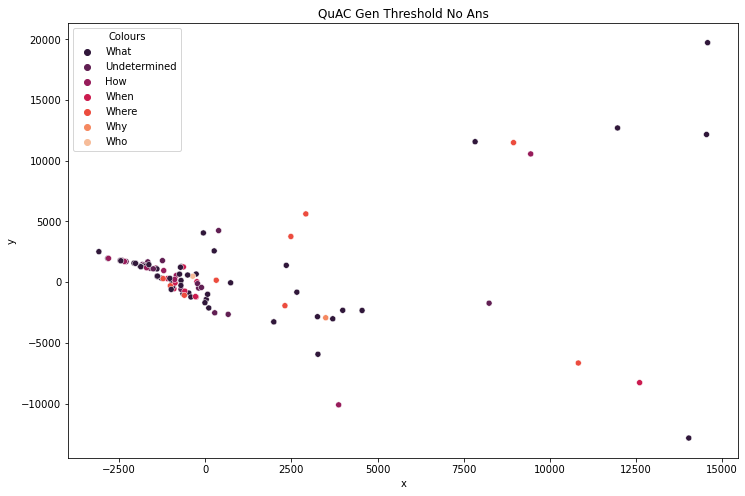

In [301]:
cluster_plot(quac_no_ans, 'QuAC Gen Threshold No Ans', 'figures/QuAC Gen No Ans - Scatter.png')


In [302]:
print(len(quac_no_ans)/len(quac_gen_thresh))

0.5101522842639594


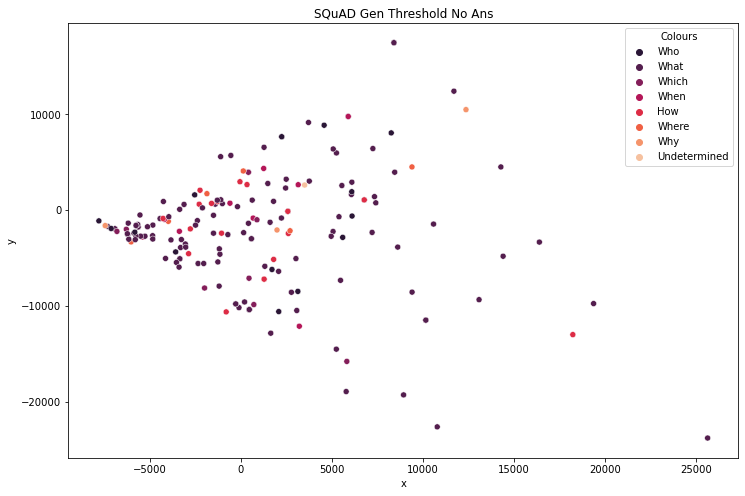

In [303]:
squad_no_ans = squad_gen_thresh[squad_gen_thresh['pred'].isin([' ', '[CLS]', 'cannotanswer'])]
cluster_plot(squad_no_ans, 'SQuAD Gen Threshold No Ans', 'figures/SQuAD Gen No Ans - Scatter.png')


In [304]:
print(len(squad_no_ans)/len(squad_gen_thresh))

0.4372549019607843


In [305]:
quac_no_ans.head(20)

,context,question,pred,original question,BLEU1,BLEU2,BLEU3,BLEU4,Meteor,Q Types,Type Code,Vectors,Reduced Vector
0,"In May 1983, she married Nikos Karvelas, a com...",What is 2017?,cannotanswer,"['what happened in 1983?', 'did they have any ...",0.015000,0.087848,0.140646,0.160571,0.000000,What,1,"[2054, 2003, 2418, 1029]","[-3093.3561016485805, 2512.7190001379217]"
2,"In April 2010, along with actors Brian Cox and...",What was the press about?,cannotanswer,"['What charity work did he do?', 'Was it a suc...",0.026178,0.115806,0.168627,0.184134,0.054348,What,1,"[2054, 2001, 1996, 2811, 2055, 1029]","[-1581.0812928687337, 1123.213707387784]"
5,"A former friend from the Mobile slums, Alex He...",Any other interesting fact about the article?,[CLS],"['what did he do in Chattanooga', 'how did he ...",0.017647,0.094561,0.147159,0.165860,0.091743,Undetermined,7,"[2151, 2060, 5875, 2755, 2055, 1996, 3720, 1029]","[2348.381547738959, 1384.6226579858615]"
8,"In 1900 Bryan ran as an anti-imperialist, find...",What was the state of the free silver?,cannotanswer,['Did Bryan run for president in the 1900 elec...,0.014085,0.083732,0.135280,0.155269,0.138889,What,1,"[2054, 2001, 1996, 2110, 1997, 1996, 2489, 316...","[-462.77155881745983, -1270.440515286675]"
9,"On 6 June 1992, the Fantoft Stave Church, dati...",What is Odinism?,cannotanswer,"['Did Varg commit any arson?', 'When was the f...",0.006173,0.057532,0.107323,0.131489,0.000000,What,1,"[2054, 2003, 26195, 2964, 1029]","[14479.440888983323, 17697.601087792904]"
10,"In January 1993, an article in one of Norway's...",What is Black Metal?,[CLS],"['what is bergens tidende?', 'what was the rea...",0.021672,0.107786,0.162412,0.179964,0.095238,What,1,"[2054, 2003, 2304, 3384, 1029]","[-1673.7031726285754, 1672.3832836605827]"
11,"The Prince of Wales, Albert Edward (""Bertie"", ...",What was she called?,cannotanswer,"[""Who's mistress was Lillie Langtry?"", 'How di...",0.033708,0.130976,0.182635,0.195450,0.131579,What,1,"[2054, 2001, 2016, 2170, 1029]","[-2462.3378672187005, 1780.7499726432238]"
12,Prime Minister Harold Macmillan was initially ...,How did the show go,cannotanswer,"['what was the reception about', 'Why did they...",0.033149,0.129989,0.181788,0.194801,0.120482,How,6,"[2129, 2106, 1996, 2265, 2175]","[-2034.531346496634, 1539.0226935426501]"
13,"Le Guin was influenced by fantasy writers, inc...",When did she prepare,cannotanswer,"['what influenced her?', 'who were they?', 'ho...",0.021368,0.105589,0.159288,0.176753,0.121951,When,3,"[2043, 2106, 2016, 7374]","[-267.6390833956941, 671.5391704370747]"
17,"In 2004, Oldman returned to prominence when he...",What did he do in the 2005 film?,[CLS],"['What was his resurgence or comeback role?', ...",0.032787,0.129344,0.181233,0.194375,0.087719,What,1,"[2054, 2106, 2002, 2079, 1999, 1996, 2384, 214...","[-652.9452069356748, -941.8509128799612]"
